# RL coursework, part II (25 pts total)
---

**Name:** Your Name

**SN:** Your Student Number

---

**Due date:** *April 10th, 2025*

---

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<studentnumber>_RL_part2.ipynb`** before the deadline above, where `<studentnumber>` is your student number.

----
**Reminder of copyrights**

Copyrights protect this code/content and distribution or usages of it (or parts of it) without permission is prohibited. This includes uploading it and usage of it in training in any LLMs systems.

## Context

In this part, we will take a first look at learning algorithms for sequential decision problems.

## Background reading

* Sutton and Barto (2018), Chapters 3 - 6

# The Assignment

### Objectives

You will use Python to implement several reinforcement learning algorithms.

You will then run these algorithms on a few problems, to understand their properties.

## Setup

### Import Useful Libraries

In [1]:
import matplotlib.collections as mcoll
import matplotlib.pyplot as plt
import numpy as np

### Set options

In [2]:
np.set_printoptions(precision=3, suppress=1)

### Some grid world

In [3]:
W = -100  # wall
G = 100  # goal

GRID_LAYOUT = np.array([
  [W, W, W, W, W, W, W, W, W, W, W, W],
  [W, W, 0, W, W, W, W, W, W, 0, W, W],
  [W, 0, 0, 0, 0, 0, 0, 0, 0, G, 0, W],
  [W, 0, 0, 0, W, W, W, W, 0, 0, 0, W],
  [W, 0, 0, 0, W, W, W, W, 0, 0, 0, W],
  [W, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, W],
  [W, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, W],
  [W, W, 0, 0, 0, 0, 0, 0, 0, 0, W, W],
  [W, W, W, W, W, W, W, W, W, W, W, W]
])

class Grid(object):

  def __init__(self, noisy=False):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = GRID_LAYOUT
    self._start_state = (2, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._noisy = noisy

  @property
  def number_of_states(self):
    return self._number_of_states

  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x

  def obs_to_state(self, obs):
    x = obs % self._layout.shape[1]
    y = obs // self._layout.shape[1]
    s = np.copy(grid._layout)
    s[y, x] = 4
    return s

  def step(self, action):
    y, x = self._state

    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    reward = self._layout[new_y, new_x]
    if self._layout[new_y, new_x] == W:  # wall
      discount = 0.9
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = -1.
      discount = 0.9
    else:  # a goal
      discount = 0.
      new_state = self._start_state

    if self._noisy:
      width = self._layout.shape[1]
      reward += 10*np.random.normal(0, width - new_x + new_y)

    self._state = new_state
    return reward, discount, self.get_obs()

  def plot_grid(self):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout != W, interpolation="nearest", cmap='pink')
    plt.gca().grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(2, 2, r"$\mathbf{S}$", ha='center', va='center')
    plt.text(9, 2, r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)


### Helper functions
(You should not have to change, or even look at, these.  Do run the cell to make sure the functions are loaded though.)

In [4]:
def run_experiment(env, agent, number_of_steps):
  mean_reward = 0.
  try:
    action = agent.initial_action()
  except AttributeError:
    action = 0
  for _ in range(number_of_steps):
    reward, discount, next_state = env.step(action)
    action = agent.step(reward, discount, next_state)
    mean_reward += reward
  return mean_reward/float(number_of_steps)

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_values(grid, values, colormap='pink', vmin=0, vmax=10):
  plt.imshow(values - 1000*(grid<0), interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_action_values(grid, action_values, vmin=-5, vmax=5):
  q = action_values
  fig = plt.figure(figsize=(10, 10))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  for a in [0, 1, 2, 3]:
    plt.subplot(4, 3, map_from_action_to_subplot(a))
    plot_values(grid, q[..., a], vmin=vmin, vmax=vmax)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")

  plt.subplot(4, 3, 5)
  v = np.max(q, axis=-1)
  plot_values(grid, v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

  # Plot arrows:
  plt.subplot(4, 3, 11)
  plot_values(grid, grid==0, vmax=1)
  for row in range(len(grid)):
    for col in range(len(grid[0])):
      if grid[row][col] == 0:
        argmax_a = np.argmax(q[row, col])
        if argmax_a == 0:
          x = col
          y = row + 0.5
          dx = 0
          dy = -0.8
        if argmax_a == 1:
          x = col - 0.5
          y = row
          dx = 0.8
          dy = 0
        if argmax_a == 2:
          x = col
          y = row - 0.5
          dx = 0
          dy = 0.8
        if argmax_a == 3:
          x = col + 0.5
          y = row
          dx = -0.8
          dy = 0
        plt.arrow(x, y, dx, dy, width=0.02, head_width=0.4, head_length=0.4, length_includes_head=True, fc='k', ec='k')

def plot_rewards(xs, rewards, color):
  mean = np.mean(rewards, axis=0)
  p90 = np.percentile(rewards, 90, axis=0)
  p10 = np.percentile(rewards, 10, axis=0)
  plt.plot(xs, mean, color=color, alpha=0.6)
  plt.fill_between(xs, p90, p10, color=color, alpha=0.3)

def parameter_study(parameter_values, parameter_name, agent_constructor,
                    env_constructor, color,
                    repetitions=10, number_of_steps=int(1e4)):
  mean_rewards = np.zeros((repetitions, len(parameter_values)))
  greedy_rewards = np.zeros((repetitions, len(parameter_values)))
  for rep in range(repetitions):
    for i, p in enumerate(parameter_values):
      env = env_constructor()
      agent = agent_constructor()
      if 'eps' in parameter_name:
        agent.set_epsilon(p)
      elif 'alpha' in parameter_name:
        agent._step_size = p
      else:
        raise NameError("Unknown parameter_name: {}".format(parameter_name))
      mean_rewards[rep, i] = run_experiment(env, agent, number_of_steps)
      agent.set_epsilon(0.)
      agent._step_size = 0.
      greedy_rewards[rep, i] = run_experiment(env, agent, number_of_steps//10)
      del env
      del agent

  plt.subplot(1, 2, 1)
  plot_rewards(parameter_values, mean_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Average reward over first {} steps".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

  plt.subplot(1, 2, 2)
  plot_rewards(parameter_values, greedy_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Final rewards, with greedy policy".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])


def colorline(x, y, z):
  """
  Based on:
  http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
  http://matplotlib.org/examples/pylab_examples/multicolored_line.html
  Plot a colored line with coordinates x and y
  Optionally specify colors in the array z
  Optionally specify a colormap, a norm function and a line width
  """
  segments = make_segments(x, y)
  lc = mcoll.LineCollection(segments, array=z, cmap=plt.get_cmap('copper_r'),
                            norm=plt.Normalize(0.0, 1.0), linewidth=3)

  ax = plt.gca()
  ax.add_collection(lc)
  return lc


def make_segments(x, y):
  """
  Create list of line segments from x and y coordinates, in the correct format
  for LineCollection: an array of the form numlines x (points per line) x 2 (x
  and y) array
  """
  points = np.array([x, y]).T.reshape(-1, 1, 2)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)
  return segments


def plotting_helper_function(_x, _y, title=None, ylabel=None):
  z = np.linspace(0, 0.9, len(_x))**0.7
  colorline(_x, _y, z)
  plt.plot(0, 0, '*', color='#000000', ms=20, alpha=0.7, label='$w^*$')
  plt.plot(1, 1, '.', color='#ee0000', alpha=0.7, ms=20, label='$w_0$')
  min_y, max_y = np.min(_y), np.max(_y)
  min_x, max_x = np.min(_x), np.max(_x)
  min_y, max_y = np.min([0, min_y]), np.max([0, max_y])
  min_x, max_x = np.min([0, min_x]), np.max([0, max_x])
  range_y = max_y - min_y
  range_x = max_x - min_x
  max_range = np.max([range_y, range_x])
  plt.arrow(_x[-3], _y[-3], _x[-1] - _x[-3], _y[-1] - _y[-3], color='k',
            head_width=0.04*max_range, head_length=0.04*max_range,
            head_starts_at_zero=False)
  plt.ylim(min_y - 0.2*range_y, max_y + 0.2*range_y)
  plt.xlim(min_x - 0.2*range_x, max_x + 0.2*range_x)
  ax = plt.gca()
  ax.ticklabel_format(style='plain', useMathText=True)
  plt.legend(loc=2)
  plt.xticks(rotation=12, fontsize=10)
  plt.yticks(rotation=12, fontsize=10)
  plt.locator_params(nbins=3)
  if title is not None:
    plt.title(title, fontsize=20)
  if ylabel is not None:
    plt.ylabel(ylabel, fontsize=20)


# Section A: Tabular RL

In this section, observations will be states in the environment, so the agent state, environment state, and observation will all be the same, and we will use the word `state` interchangably with `observation`.  You will implement agents, which should be in pure Python - so you cannot use JAX/TensorFlow/PyTorch to compute gradients. Using `numpy` is fine.

### A random agent

Below we show a reference implementation of a simple random agent, implemented according to the interface above.

In [5]:
class Random(object):

  def __init__(self, number_of_actions, number_of_states, initial_state):
    self._number_of_actions = number_of_actions

  def step(self, reward, discount, next_state):
    next_action = np.random.randint(self._number_of_actions)
    return next_action

### The grid

The cell below shows the `Grid` environment that we will use in this section. Here `S` indicates the start state and `G` indicates the goal.  The agent has four possible actions: up, right, down, and left.  Rewards are: `-100` for bumping into a wall, `+100` for reaching the goal, and `-1` otherwise.  The episode ends when the agent reaches the goal, and otherwise continues.  The discount, on continuing steps, is $\gamma = 0.9$.  Feel free to reference the implemetation of the `Grid` above, under the header "a grid world".

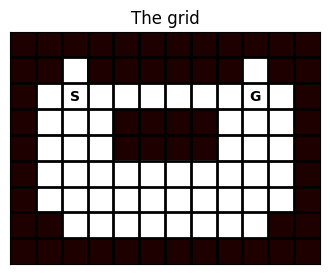

In [6]:
GRID = Grid()
GRID.plot_grid()


## Q1: Implement TD learning **[4 pts]**
Implement an agent that acts randomly, and _on-policy_ estimates state values $v(s)$, using one-step TD learning with step size $\alpha=0.1$.

Use the `__init__` as provided below.  You should implement the `step` function.  We store the initial state in the constructor because you need its value on the first `step` in order to compute the TD error when the first transition has occurred.

Also implement a property `state_values(self)` returning the vector of all state values (one value per state). (A method with the `@property` decorator can be called without the parentheses as if it's a variable, e.g., `agent.state_values` instead of `agent.state_values()`.)

In [7]:
class RandomTD(object):

  def __init__(self, number_of_states, number_of_actions, initial_state, step_size=0.1):
      self._number_of_states = number_of_states
      self._number_of_actions = number_of_actions
      self._step_size = step_size
      # Initialize all state values to 0.
      self._values = np.zeros(number_of_states)
      # Store the current state; used to update its value upon receiving a transition.
      self._current_state = initial_state

  @property
  def state_values(self):
    return self._values

  def step(self, reward, discount, next_state):
    # One-step TD update for the current state's value:
    # v(s) <- v(s) + alpha * (reward + discount * v(s') - v(s))
    td_target = reward + discount * self._values[next_state]
    td_error = td_target - self._values[self._current_state]
    self._values[self._current_state] += self._step_size * td_error

    # Update the current state to the new state
    self._current_state = next_state

    # Choose a random action (as the policy is random).
    action = np.random.randint(self._number_of_actions)
    return action

### Run the next cell to run the `RandomTD` agent on a grid world.

If everything worked as expected, the plot below will show the estimates state values under the random policy. This includes values for unreachable states --- on the walls and on the goal (we never actually reach the goal --- rather, the episode terminates on the transition to the goal.  The values on the walls and goal are, and will always remain, zero. The plotting code knows about the walls, so they appear black below.

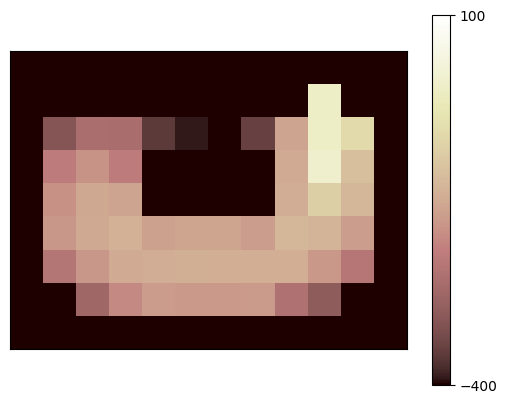

In [8]:
# Do not modify this cell.
AGENT = RandomTD(GRID._layout.size, 4, GRID.get_obs())
run_experiment(GRID, AGENT, int(1e5))
v = AGENT.state_values
plot_values(GRID_LAYOUT,
            v.reshape(GRID._layout.shape),
            colormap="pink", vmin=-400, vmax=100)

## Q2: Policy iteration **[5 pts]**
We used TD to do policy evaluation for the random policy on this problem.  Consider doing policy improvement, by taking the greedy policy with respect to a one-step look-ahead.  For this, you may assume we have a true model, so for each state and for each action we can look at the value of the resulting state, and would then pick the action with the highest reward plus subsequent state value. In other words, you can assume we can use $q(s, a) = \mathbb{E}[ R_{t+1} + \gamma v(S_{t+1}) \mid S_t = s, A_t = a]$, where $v$ is the value function learned by TD as implemented. Then we consider the policy that picks the action with the highest action value $q(s, a)$. You do **not** have to implement this, just answer the following question.

2.1 **[3pts]** The above amounts to performing an iteration of policy evaluation and policy improvement.  If we repeat this process over and over again, and repeatedly evaluate the greedy policy and then perform an improvement step by picking the greedy policy, would the policy eventually become optimal?  Explain why or why not in at most three sentences.

> *Answer here*

2.2. **[2pts]** What if you were to run a Q-learning agent on this enveromenint, and consider running to converegence, how would the value function for Q_learning compare to the one learnt by the TD agent?

> *Answer here*

# Section B: Off-policy Bellman operators with function approximation

## Q1: Bellman operator for prediction **[5 pts]**

We are going to implement the _expected_ update to the weight for a simple MDP.
In order to be able to implement this update, we need to know the MDP, as well as the way the agent's value depend on the weights and states.  This is defined as follows:

There are two states, $s_1$ and $s_2$.  All rewards are zero, and therefore can be ignored.  Instead of the underlying state, the agent observes state features $\mathbf{x}_1 = \mathbf{x}(s_1)$ and $\mathbf{x}_2 = \mathbf{x}(s_2)$.  These are defined for the two states are $\mathbf{x}_1 = [1, 1]^{\top}$ and $\mathbf{x}_2 = [2, 1]^{\top}$.  In each state, there are two actions, $a$ and $b$.  Action $a$ always transitions to state $s_1$, action $b$ always transitions to state $s_2$.

![MDP](https://hadovanhasselt.files.wordpress.com/2020/02/mdp.png)

---

The agent will make *linear* predicions, such that $v(s) = \mathbf{w}^\top \mathbf{x}(s)$. In the code cell below, you should implement an update that computes the **expected** weight update, given:
* The current weights `w`.
* A target policy $\pi$ that we want to learn about; the actual input, denoted `pi` in the code below, will be a scalar indicating the probability of selecting action `a` in both states: `pi` $= \pi(a|s), \forall s$.
* A behaviour policy $\mu$ that would be used to generate the transitions; the actual input, denoted `mu` in the code below, will be a scalar indicating the probability of selecting action `a` in both states: `mu` $= \mu(a|s), \forall s$.
* A scalar trace parameter $\lambda$ (=`trace_parameter`),
* A scalar discount parameter $\gamma$ (=`discount`).

The expectation should take into account the probabilities of actions in the future, as well as the steady-state (=long-term) probability of being in a state.  The step size of the update should be $\alpha=0.1$.

The expected update should be for a multi-step $\lambda$-return and should be correct for any pair of target and any behaviour policy.  It should be the expectation of performing a (forward view) TD($\lambda$) update in the MDP described above when the _state distribution_ is generated by the behaviour policy and the _returns_ from each state are generated by the target policy. We will use the update you implement to generate plots below.


In [9]:
# state features (do not change)
x1 = np.array([1., 1.])
x2 = np.array([2., 1.])

def expected_update(w, pi, mu, trace_parameter, discount, lr):
  alpha = lr
  # Define the state features:
  x1 = np.array([1., 1.])
  x2 = np.array([2., 1.])

  # Compute current value estimates:
  v1 = np.dot(w, x1)
  v2 = np.dot(w, x2)

  # Under the target policy (pi for action a leads to s1, 1-pi for action b leads to s2),
  # the expected value for the next state is:
  v_bar = pi * v1 + (1 - pi) * v2

  # Compute the multi-step λ-return (forward view) in our reward-free MDP:
  G_lambda = discount * (1 - trace_parameter) / (1 - trace_parameter * discount) * v_bar

  # TD errors for each state:
  td_error1 = G_lambda - v1
  td_error2 = G_lambda - v2

  # The behaviour policy gives state s1 with probability mu, and s2 with probability (1-mu).
  expected_weight_update = mu * td_error1 * x1 + (1 - mu) * td_error2 * x2

  return alpha * expected_weight_update
  #return expected_weight_update

##Experiment: run the cell below
The cell below runs an experiment, across different target policies and trace parameters $\lambda$.

The plots below the cell will show how the weights move within the 2-dimensional weight space, starting from $w_0 = [1, 1]^{\top}$ (shown as red dot).  The optimal solution $w_* = [0, 0]^{\top}$ is also shown (as black star).

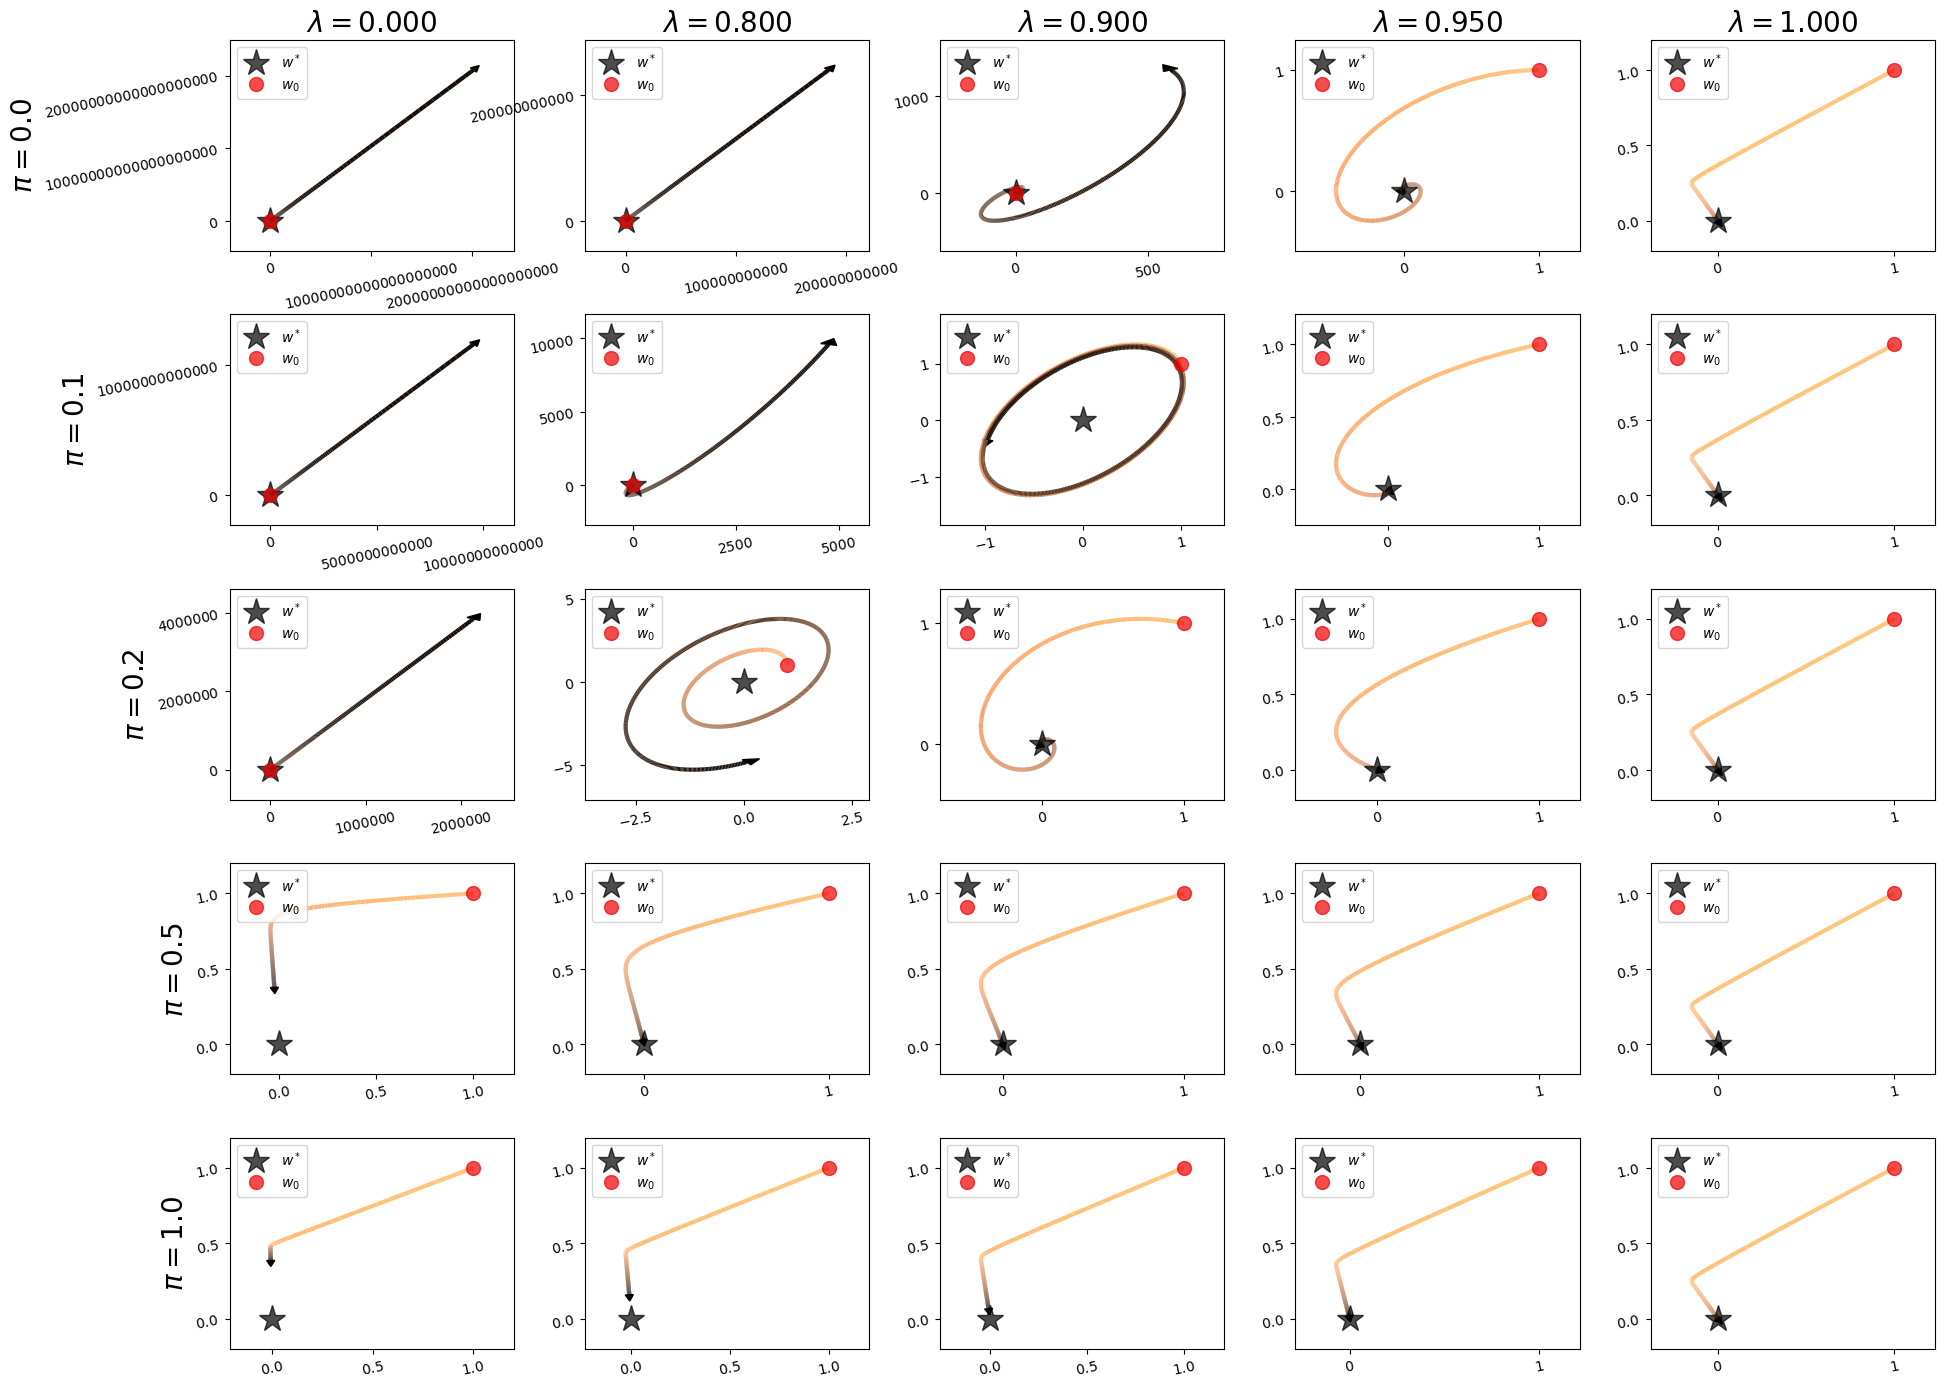

In [10]:
def generate_ws(w, pi, mu, l, g):
  """Apply the expected update 1000 times"""
  ws = [w]
  for _ in range(1000):
    w = w + expected_update(w, pi, mu, l, g, lr=0.1)
    ws.append(w)
  return np.array(ws)

mu = 0.5  # behaviour
g = 0.99  # discount

lambdas = np.array([0, 0.8, 0.9, 0.95, 1.])
pis = np.array([0., 0.1, 0.2, 0.5, 1.])

fig = plt.figure(figsize=(22, 17))
fig.subplots_adjust(wspace=0.25, hspace=0.3)

for r, pi in enumerate(pis):
  for c, l in enumerate(lambdas):
    plt.subplot(len(pis), len(lambdas), r*len(lambdas) + c + 1)
    w = np.ones_like(x1)
    ws = generate_ws(w, pi, mu, l, g)
    title = '$\\lambda={:1.3f}$'.format(l) if r == 0 else None
    ylabel = '$\\pi={:1.1f}$'.format(pi) if c == 0 else None
    plotting_helper_function(ws[:, 0], ws[:, 1], title, ylabel)

## Q2: Analyse results (11 pts total)
1. **[1 pts]** How many of the above 25 experiments diverge?
1. **[1 pts]** For which policies $\pi$, is the true value function $v_{\pi}$ representable in the above feature space (spanned by $x_1, x_2$).
1. **[2 pts]** Why are the results asymmetric across different $\pi$?  In particular, explain why the results look different when comparing $\pi = \pi(a | \cdot) = 0$ to $\pi(a | \cdot) = 1$.
1. **[2 pts]** For which combination of $\pi(a)$ and $\lambda$ does the expected update (with uniform random behaviour) converge? Do not limit the answer to the subset of values in the plots above, but to all possible choices of $\lambda \in [0, 1]$ and $\pi(a|s) \in [0, 1]$, but do restrict yourself to state-less policies, as above, for which the action probabilities are equal in the two states: $\pi(a|s_1) = \pi(a|s_2)$.
1. **[1 pts]** Why do all the plots corresponding to full Monte Carlo update look the same (right column)?
1. **[2 pts]** Why do the plots corresponding to full Monte Carlo have the shape they do?
1. **[2 pts]** The plots above are for uniform behavoiur: $\mu(a|s) = \mu(b|s) = 0.5$.  How would the results change (high level, not in terms of precise plots) if the behaviour policy $\mu$ would select action $a$ more often (e.g., $\mu = 0.8$)?  How would the results change if the behaviour would select $a$ less often (e.g., $\mu = 0.2$)?


## Put answers to Q8 in this cell:
1. _...answer here..._
2. _...answer here..._
3. _...answer here..._
4. _...answer here..._
5. _...answer here..._
6. _...answer here..._
7. _...answer here..._
